In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem.snowball import GermanStemmer
#!pip install gensim
import gensim
import gensim.corpora as corpora
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, LeaveOneOut, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Pre-processing

In [2]:
nltk.download('stopwords')
stopwords_l = stopwords.words("german")

def tokenize(text):
    nltk.download('stopwords')
    stopwords_l = stopwords.words("german")
    tokens = gensim.utils.simple_preprocess(text, deacc=True)
    tokens = [token for token in tokens if token not in stopwords_l]
    return tokens



def clean_text(df: pd.DataFrame, x : str):

    df[x] = df[x].str.lower()
    df[x] = df[x].replace(r"^(.*?),","",regex= True)
    # df[x] = df[x].replace(r"(viele|mit|herzliche|liebe|beste|freundliche).*grüß.*", "", regex=True) # zu breit, fuehrt teilw zu fehlern
    df[x] = df[x].replace(
    r"(mit\s+(freundlichen?|besten?)\s+grüß\w*|"
    r"freundlich\w*\s+grüß\w*|"
    r"herzlich\w*\s+grüß\w*|"
    r"viel\w*\s+grüß\w*|"
    r"lieb\w*\s+grüß\w*|"
    r"beste\s+grüß\w*)\s*.*$",
    "",
    regex=True)
    df[x] = df[x].replace(r" bitte*", "", regex=True)
    df[x] = df[x].replace(r"vielen dank.*","",regex = True)
    df[x] = df[x].replace(r'[^\s\w]+','',regex = True)

    return df


def remove_stopwords_from_series(text):
    words = text.split()
    words_filtered = [w for w in words if w not in stopwords_l]
    return " ".join(words_filtered)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_excel("20250602_Anfragen_Sample.xlsx")
df_clean = clean_text(df, "Kundenanfrage")
df_clean["Kundenanfrage"] = df_clean["Kundenanfrage"].apply(remove_stopwords_from_series)
df_clean["tokens"] = df_clean["Kundenanfrage"].str.split()
id2word = corpora.Dictionary(df_clean["tokens"])
texts = df_clean["tokens"]
corpus = [id2word.doc2bow(text) for text in texts]

# Descriptive Figures

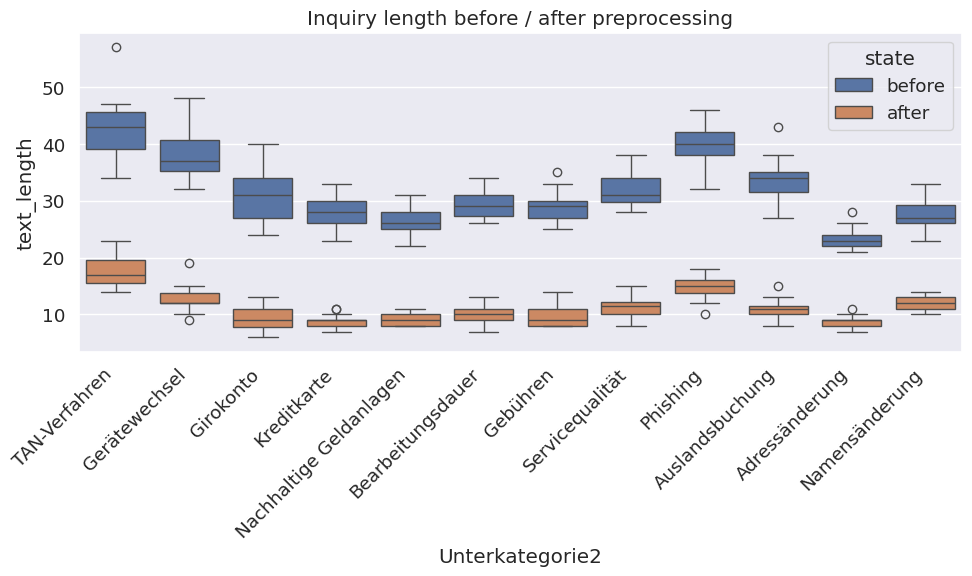

In [5]:
df = pd.read_excel("20250602_Anfragen_Sample.xlsx")
df["text_length"] = df["Kundenanfrage"].apply(lambda x: len(str(x).split()))
df_clean["text_length"] = df_clean["Kundenanfrage"].apply(lambda x: len(str(x).split()))
df["state"] = "before"
df_clean["state"] = "after"
df_comb = pd.concat([df, df_clean])

sns.set(font_scale=1.2)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_comb,x='Unterkategorie2', y='text_length',hue='state',dodge=False)
plt.xticks(rotation=45, ha='right')
plt.title('Inquiry length before / after preprocessing')
plt.tight_layout()
plt.show()

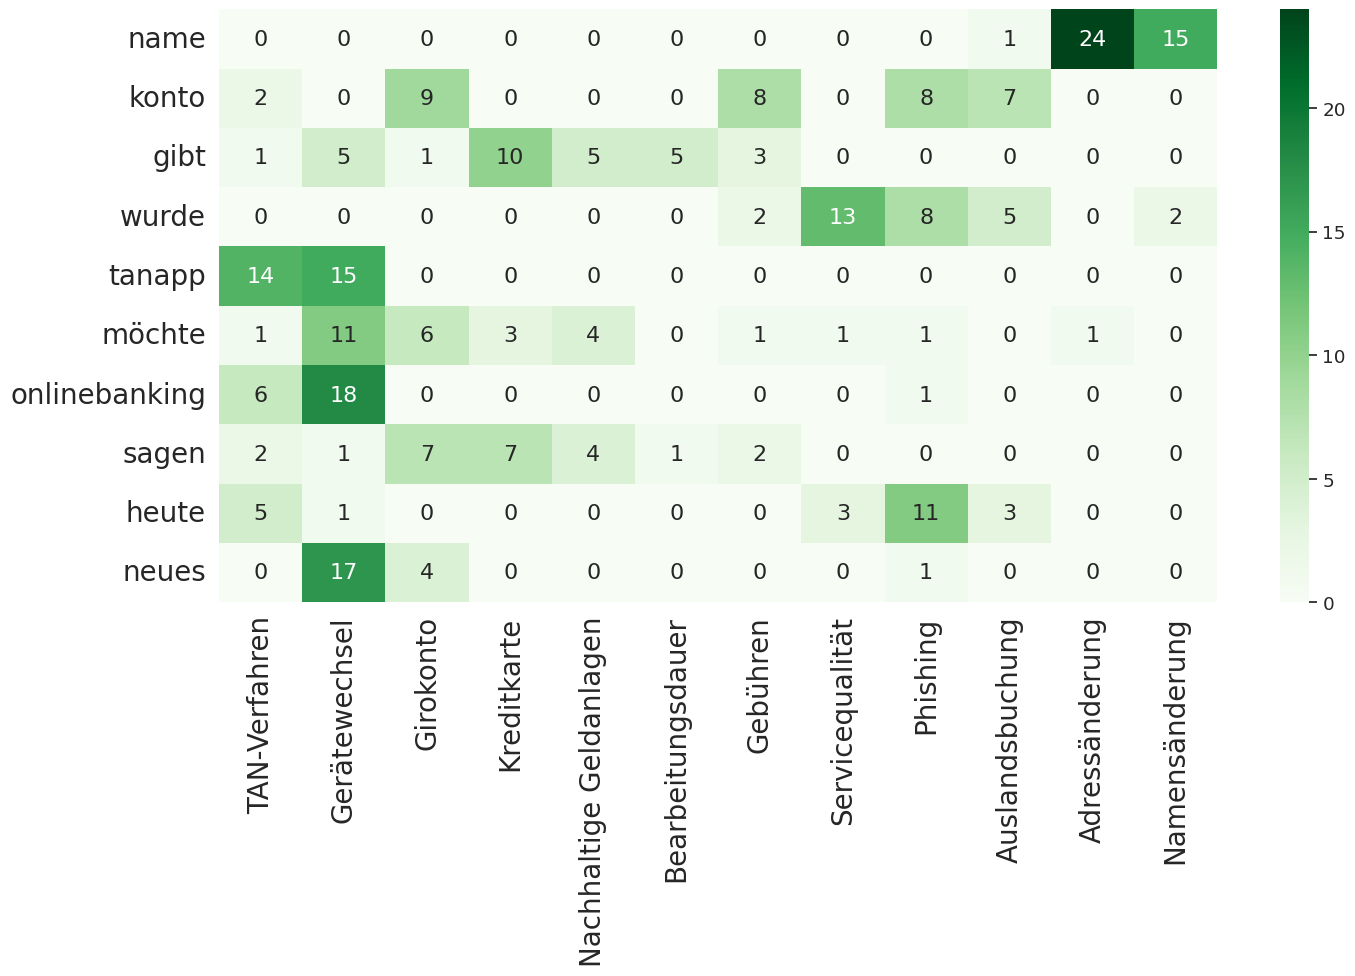

In [6]:
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_tokens = df_clean["tokens"].explode()
word_counts = Counter(all_tokens)

topwords = [word for word, _ in word_counts.most_common(10)]
categories = df_clean["Unterkategorie2"].unique()
heatmap_data = pd.DataFrame(0, index=topwords, columns=categories)

for _, row in df_clean.iterrows():
    tokens = row["tokens"]
    category = row["Unterkategorie2"]
    for token in tokens:
        if token in topwords:
            heatmap_data.at[token, category] += 1

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, annot_kws={"size": 16}, cmap='Greens')
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20, rotation=0)
plt.tight_layout()
plt.show()

Adressänderung


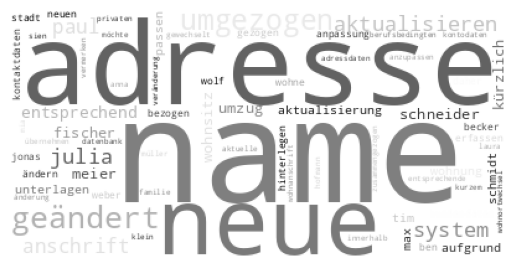

Auslandsbuchung


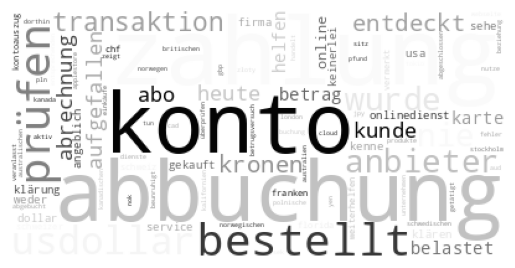

Bearbeitungsdauer


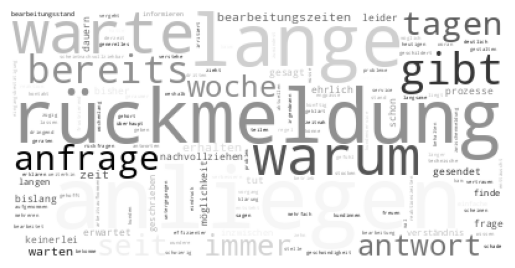

Gebühren


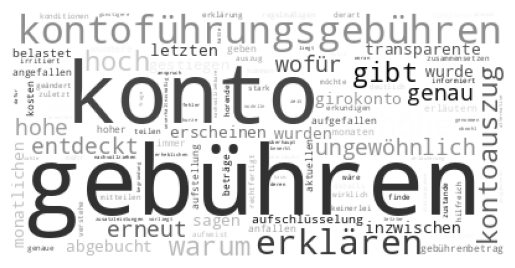

Gerätewechsel


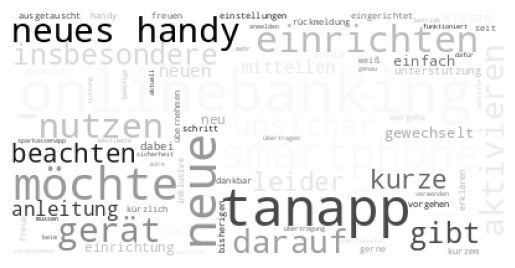

Girokonto


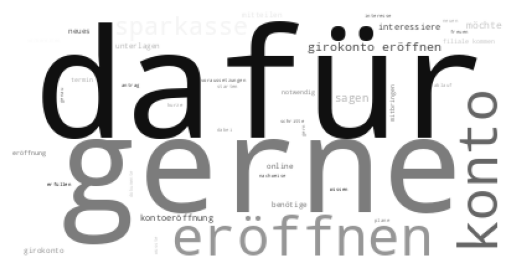

Kreditkarte


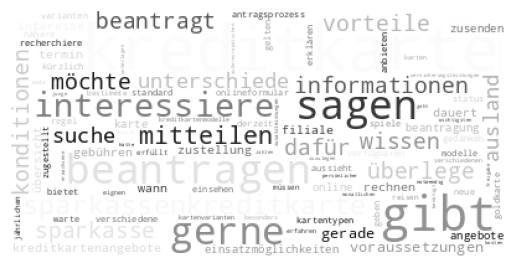

Nachhaltige Geldanlagen


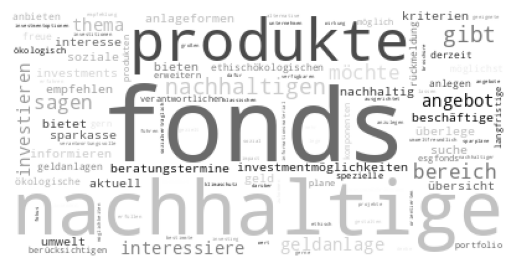

Namensänderung


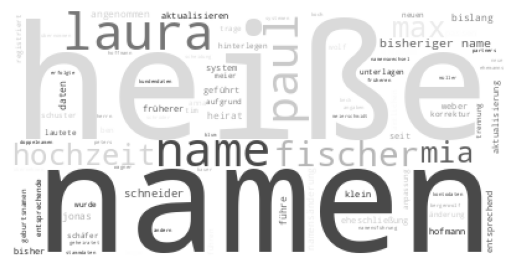

Phishing


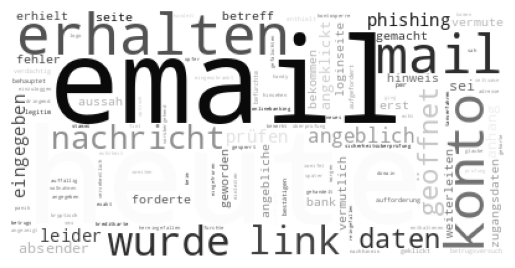

Servicequalität


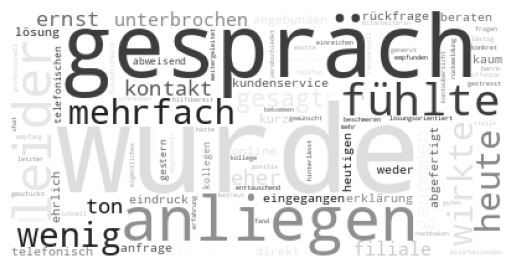

TAN-Verfahren


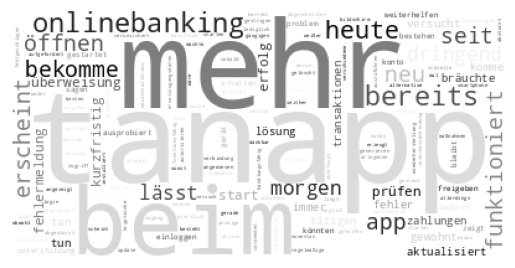

In [7]:
# word clouds
df_group = pd.DataFrame(df_clean.groupby("Unterkategorie2")["Kundenanfrage"].agg(lambda x: " ".join(x))) #combine each category
wordcloud_dic = {}
for index,row in df_group.iterrows():
    wc = WordCloud(background_color='white', colormap = 'binary').generate(row["Kundenanfrage"])
    wordcloud_dic[index] = wc
for k,v in wordcloud_dic.items():
    print(k)
    plt.axis("off")
    plt.imshow(v)
    plt.show()

# Logistic Regression with TF-IDF

In [10]:
x = df_clean["Kundenanfrage"].astype(str)
y = df_clean["Unterkategorie2"].astype(str)

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        min_df=0.01,
        max_df=0.8
    )),
    ("lr", LogisticRegression(max_iter=2000))
])

param1 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l1','l2'],
    'lr__solver': ['liblinear'],
    'lr__class_weight': [None, 'balanced'],
    'lr__multi_class': ['ovr']
}

param2 = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l2'], # lbfgs nur mit L2 (oder none)
    'lr__solver': ['lbfgs', 'newton-cg'],
    'lr__class_weight': [None, 'balanced'],
    'lr__multi_class': ['ovr']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param2,
    cv=LeaveOneOut(),
    scoring='accuracy',
    #scoring='f1_macro',
    n_jobs=-1
)
grid.fit(x, y)

best_lr = grid.best_estimator_
print("best params", grid.best_params_)
print("mean acc", grid.best_score_)

y_pred_loo = cross_val_predict(best_lr, x, y, cv=LeaveOneOut(), n_jobs=-1)
print(classification_report(y, y_pred_loo))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


best params {'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__multi_class': 'ovr', 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}
mean acc 0.963855421686747
                         precision    recall  f1-score   support

         Adressänderung       0.92      0.96      0.94        24
        Auslandsbuchung       1.00      1.00      1.00        23
      Bearbeitungsdauer       0.95      0.91      0.93        22
               Gebühren       0.94      1.00      0.97        17
          Gerätewechsel       1.00      0.95      0.98        22
              Girokonto       0.96      1.00      0.98        24
            Kreditkarte       0.96      0.96      0.96        27
Nachhaltige Geldanlagen       0.95      0.95      0.95        19
         Namensänderung       0.95      0.95      0.95        20
               Phishing       1.00      0.95      0.97        20
        Servicequalität       1.00      0.94      0.97        16
          TAN-Verfahren       0.94      1.00      0.97        15


In [11]:
# wrong classifications
df_results = pd.DataFrame({
    "text": x,
    "true": y,
    "pred": y_pred_loo
})
df_results[df_results["true"] != df_results["pred"]]

,text,true,pred
17,neues mobiltelefon gerne wissen nutzung sparka...,Gerätewechsel,Kreditkarte
75,interessiere beantragung sparkassenkreditkarte...,Kreditkarte,Girokonto
96,denke darüber geld nachhaltig anzulegen empfeh...,Nachhaltige Geldanlagen,Bearbeitungsdauer
111,vorgang scheint stocken geraten erklären wesha...,Bearbeitungsdauer,Gebühren
128,verständnis betrieb hätte zumindest zwischenme...,Bearbeitungsdauer,Nachhaltige Geldanlagen
148,letzter besuch filiale leider enttäuschend mit...,Servicequalität,TAN-Verfahren
169,versehentlich zugangsdaten gefälschten loginse...,Phishing,Adressänderung
224,name laura hofmann wohnortwechsel aktualisiere...,Adressänderung,Namensänderung
230,name bisher anna meier geheiratet trage namen ...,Namensänderung,Adressänderung


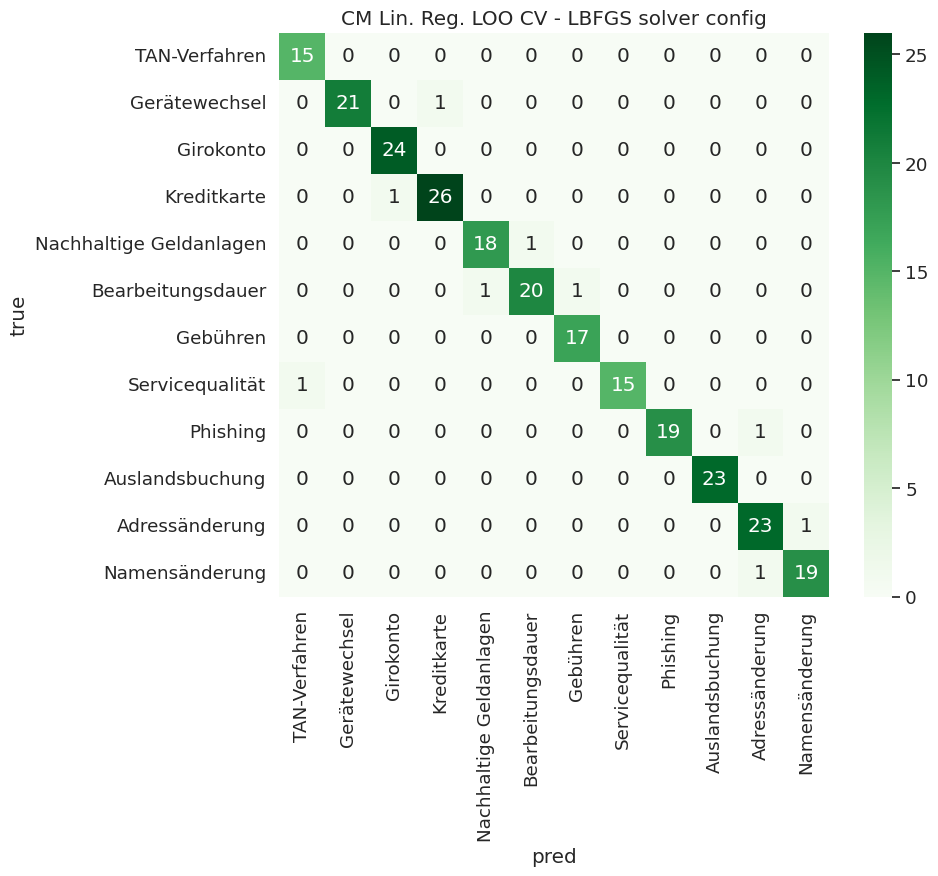

In [13]:
labels = y.unique()
plt.figure(figsize=(10, 9))
sns.heatmap(confusion_matrix(y, y_pred_loo, labels=labels), annot=True, cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("pred")
plt.ylabel("true")
plt.title("CM Lin. Reg. LOO CV - LBFGS solver config")
plt.tight_layout()
plt.show()

In [16]:
# top words by coefficient
best_lr.fit(x, y)
vectorizer = best_lr.named_steps["tfidf"]
feature_names = np.array(vectorizer.get_feature_names_out())
lr_model = best_lr.named_steps["lr"]

for class_idx, class_label in enumerate(lr_model.classes_):
    coefs = lr_model.coef_[class_idx]
    top_pos_idx = np.argsort(coefs)[-10:]
    top_neg_idx = np.argsort(coefs)[:10]

    print(class_label)
    print("positive:")
    for i in reversed(top_pos_idx):
        print(f"{feature_names[i]:<20} {coefs[i]:.4f}")
    print("negative:")
    for i in top_neg_idx:
        print(f"{feature_names[i]:<20} {coefs[i]:.4f}")

Adressänderung
positive:
name                 3.2955
adresse              2.2850
geändert             1.8656
umgezogen            1.5622
neue                 1.5576
aktualisieren        1.3808
anschrift            1.3334
julia                1.2391
name julia           1.2391
entsprechend         1.2379
negative:
wurde                -0.5898
heiße                -0.5597
konto                -0.5387
gibt                 -0.5260
namen                -0.5068
sagen                -0.4675
kreditkarte          -0.4338
tanapp               -0.3774
dafür                -0.3772
heute                -0.3565
Auslandsbuchung
positive:
abbuchung            2.6803
zahlung              2.5433
bestellt             2.2870
transaktion          2.1350
usdollar             1.8181
kronen               1.7488
betrag               1.4460
anbieter             1.4317
entdeckt             1.3952
konto wurde          1.3581
negative:
gibt                 -0.6334
sagen                -0.5528
gebühren             

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


# SVM

In [ ]:
# TF-IDF Vectorization with Support Vector Machiene
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # unigrams + bigrams
    min_df=2,
    max_df=0.9
)
X = vectorizer.fit_transform(df_clean["Kundenanfrage"])
y = df_clean["Unterkategorie2"]

# Encode labels
y_encoded = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],  # 'linear' is often best for text data
    'class_weight': [None, 'balanced']
}

# Grid search
svc = SVC()
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best estimator
best_svm = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Predict & evaluate
y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best parameters: {'C': 10, 'class_weight': None, 'kernel': 'linear'}
Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        10
           2       1.00      0.83      0.91         6
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         3

    accuracy                           0.98        50
   macro avg       0.97      0.99      0.98        50
weighted avg       0.99      0.98      0.98        50



In [ ]:
# Konfusionsmatrix berechnen für SVM
labels = sorted(set(y_test))
category_labels = encoder.inverse_transform(labels)

cm = confusion_matrix(y_test, y_pred_SVM, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix SVM Train/Test split")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Braucht ca. 4min
# Data preparation
X_text = df_clean["Kundenanfrage"].astype(str)  # Feature: customer queries
y_labels = df_clean["Unterkategorie2"].astype(str)  # Target: subcategories

# Pipeline: TF-IDF vectorization + SVM classifier
svm_loo_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        min_df=0.01,
        max_df=0.8
    )),
    ("svc", SVC())
])

# Hyperparameter grid for SVM with Leave-One-Out CV
svm_loo_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__class_weight': [None, 'balanced'],
    'svc__gamma': ['scale', 'auto']
}

# Leave-One-Out cross-validation setup
loo_cv = LeaveOneOut()

# GridSearchCV using LOO cross-validation
svm_loo_grid = GridSearchCV(
    estimator=svm_loo_pipeline,
    param_grid=svm_loo_param_grid,
    cv=loo_cv,
    scoring='accuracy',
    n_jobs=-1
)
svm_loo_grid.fit(X_text, y_labels)

# Best SVM model found with LOO CV
best_svm_loo = svm_loo_grid.best_estimator_
print("Best parameters (SVM LOO):", svm_loo_grid.best_params_)
print("LOO mean accuracy (SVM):", svm_loo_grid.best_score_)

# Obtain Leave-One-Out predictions for all samples
y_pred_svm_loo = cross_val_predict(best_svm_loo, X_text, y_labels, cv=loo_cv, n_jobs=-1)

# Classification report for SVM with LOO CV
print("\nClassification Report (SVM LOO):")
print(classification_report(y_labels, y_pred_svm_loo))

# Confusion matrix for SVM with LOO CV
svm_loo_labels = sorted(y_labels.unique())
cm_svm_loo = confusion_matrix(y_labels, y_pred_svm_loo, labels=svm_loo_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm_loo, annot=True, fmt='d', cmap='Greens',
            xticklabels=svm_loo_labels, yticklabels=svm_loo_labels)
plt.xlabel("Predicted (SVM LOO)")
plt.ylabel("True (SVM LOO)")
plt.title("Confusion Matrix - SVM with Leave-One-Out CV")
plt.tight_layout()
plt.show()

In [ ]:
# Create a DataFrame with true and predicted labels
df_results = pd.DataFrame({
    "Text": X_text,
    "True Label": y_labels,
    "Predicted Label": y_pred_svm_loo
})

# Filter only the misclassified rows
df_misclassified = df_results[df_results["True Label"] != df_results["Predicted Label"]]

# Print the number of misclassified samples
print(f"Misclassified: {len(df_misclassified)} out of {len(df_results)} observations")

# Display the misclassified samples
df_misclassified